In [ ]:
# !pip install ultralytics


import ultralytics
from ultralytics import YOLO
import os
import shutil
import random
import xml.etree.ElementTree as ET
from glob import glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import files
files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d andrewmvd/road-sign-detection
# !unzip -q road-sign-detection.zip -d ./road_sign_dataset

print("데이터셋 다운로드 완료")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 63% 137M/218M [00:00<00:00, 1.42GB/s]
100% 218M/218M [00:00<00:00, 951MB/s] 
데이터셋 다운로드 완료


In [ ]:
classes = ['trafficlight', 'stop', 'speedlimit', 'crosswalk']
class_map = {name: i for i, name in enumerate(classes)}

base_path = './datasets/road_sign'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

for split in ['train', 'val']:
    os.makedirs(os.path.join(images_path, split), exist_ok=True)
    os.makedirs(os.path.join(labels_path, split), exist_ok=True)

def convert_annotation(xml_file, output_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(output_path, 'w') as f:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in class_map: continue
            cls_id = class_map[cls]
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            # YOLO 좌표 변환 (center_x, center_y, width, height)
            bb = ((b[0] + b[1]) / 2.0 / w, (b[2] + b[3]) / 2.0 / h,
                  (b[1] - b[0]) / w, (b[3] - b[2]) / h)
            f.write(f"{cls_id} {bb[0]} {bb[1]} {bb[2]} {bb[3]}\n")

all_images = glob('./road_sign_dataset/images/*.png')
random.shuffle(all_images)
split_idx = int(len(all_images) * 0.8) # 8:2 비율
train_imgs, val_imgs = all_images[:split_idx], all_images[split_idx:]

for img_file, split in [(train_imgs, 'train'), (val_imgs, 'val')]:
    for img in img_file:
        shutil.copy(img, os.path.join(images_path, split))

        xml_file = img.replace('images', 'annotations').replace('.png', '.xml')
        txt_filename = os.path.basename(img).replace('.png', '.txt')
        txt_path = os.path.join(labels_path, split, txt_filename)
        convert_annotation(xml_file, txt_path)

print("데이터 구조 정리 및 변환 완료!")

데이터 구조 정리 및 변환 완료!


In [ ]:
yaml_content = f"""
path: {os.path.abspath(base_path)}
train: images/train
val: images/val

names:
  0: trafficlight
  1: stop
  2: speedlimit
  3: crosswalk
"""

with open('road_sign_data.yaml', 'w') as f:
    f.write(yaml_content)

print("road_sign_data.yaml 생성 완료")

road_sign_data.yaml 생성 완료


In [ ]:
model = YOLO('yolov8n.pt')

results = model.train(
    data='road_sign_data.yaml',
    epochs=20,
    imgsz=640,
    batch=16,
    name='road_sign_model'
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road_sign_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_sign_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=


image 1/1 /content/datasets/road_sign/images/val/road783.png: 640x480 1 speedlimit, 38.4ms
Speed: 2.4ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict


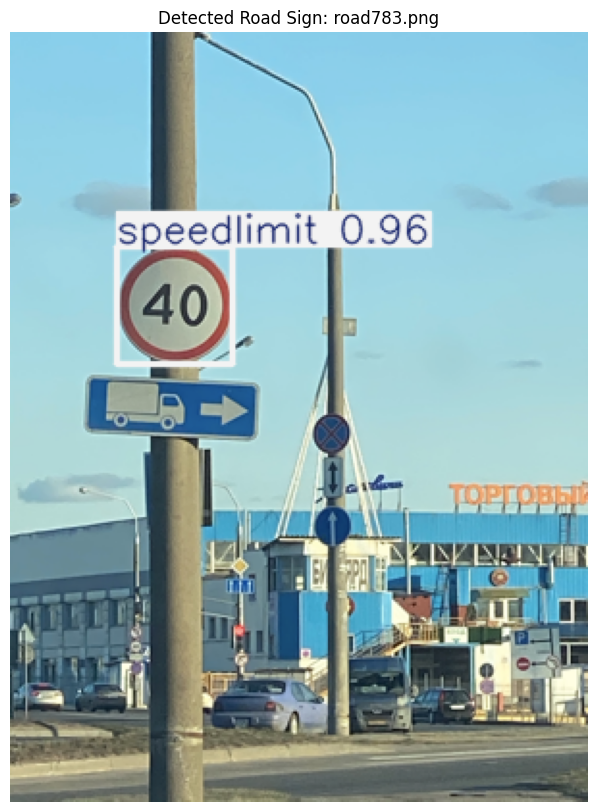

테스트 이미지 경로: ./datasets/road_sign/images/val/road783.png


In [ ]:
test_image = random.choice(glob(f'{images_path}/val/*.png'))

results = model.predict(source=test_image, conf=0.25, save=True)

for result in results:
    res_plot = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Detected Road Sign: {os.path.basename(test_image)}")
    plt.show()

print(f"테스트 이미지 경로: {test_image}")